In [1]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('data/wfp_food_prices_sdn.csv', parse_dates=['date'])
df.head(100)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,2001-01-15,Blue Nile,Damazin,Damazin,11.7891,34.3592,cereals and tubers,Sorghum (white),90 KG,actual,Wholesale,SDG,46.00,17.8728
1,2001-01-15,Gedaref,Al Gedaref Rural,El Gedarif,14.0400,35.3800,cereals and tubers,Sorghum (white),90 KG,actual,Wholesale,SDG,51.67,20.0758
2,2001-01-15,Khartoum,Jebal Aulya,Khartoum,15.5126,32.5436,cereals and tubers,Millet,90 KG,actual,Wholesale,SDG,77.29,30.0302
3,2001-01-15,Khartoum,Jebal Aulya,Khartoum,15.5126,32.5436,cereals and tubers,Sorghum (white),90 KG,actual,Wholesale,SDG,63.90,24.8277
4,2001-01-15,Khartoum,Jebal Aulya,Khartoum,15.5126,32.5436,cereals and tubers,Wheat,90 KG,actual,Wholesale,SDG,81.50,31.6660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2001-11-15,Northern,Dongola,Dongola,19.1700,30.4700,cereals and tubers,Sorghum (white),90 KG,actual,Wholesale,SDG,50.00,19.1395
96,2001-11-15,Northern,Dongola,Dongola,19.1700,30.4700,cereals and tubers,Wheat,90 KG,actual,Wholesale,SDG,55.33,21.1798
97,2001-12-15,Blue Nile,Damazin,Damazin,11.7891,34.3592,cereals and tubers,Sorghum (white),90 KG,actual,Wholesale,SDG,26.33,10.0610
98,2001-12-15,Gedaref,Al Gedaref Rural,El Gedarif,14.0400,35.3800,cereals and tubers,Millet,90 KG,actual,Wholesale,SDG,36.70,14.0235


In [13]:
df.market.unique()

array(['Damazin', 'El Gedarif', 'Khartoum', 'El Obeid', 'Al Fashir',
       'Dongola', 'Eddein', 'Kassala', 'Port Sudan', 'Nyala',
       'El Geneina', 'Kosti', 'Kadugli', 'Zalingi', 'El Fula',
       'Wad Medani', 'Ed Damer', 'Singa'], dtype=object)

In [11]:
len(df.latitude.unique())

18

In [14]:
df2 = pd.read_csv('data/food_crises_cleaned.csv', parse_dates=['date'])

In [15]:
df2.head()

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date
0,South Sudan,74,Bor,32.00486,6.465644,2007_01,2007,1,NaN,NaN,...,0.048880,0,0,0.561363,14008.33,7.961984,239344.0,11393.76,90.8503,2007-01-01
1,South Sudan,74,Bor,32.00486,6.465644,2007_02,2007,2,NaN,NaN,...,-0.457928,0,0,0.565693,14008.33,7.961984,239344.0,11393.76,90.8503,2007-02-01
2,South Sudan,74,Bor,32.00486,6.465644,2007_03,2007,3,NaN,NaN,...,-0.590175,0,0,0.592437,14008.33,7.961984,239344.0,11393.76,90.8503,2007-03-01
3,South Sudan,74,Bor,32.00486,6.465644,2007_04,2007,4,NaN,NaN,...,-1.845536,0,0,0.605352,14008.33,7.961984,239344.0,11393.76,90.8503,2007-04-01
4,South Sudan,74,Bor,32.00486,6.465644,2007_05,2007,5,NaN,NaN,...,-2.972735,0,0,0.618699,14008.33,7.961984,239344.0,11393.76,90.8503,2007-05-01


In [19]:
df.longitude.unique()

array([34.3592    , 35.38      , 32.5436    , 30.21858   , 25.35      ,
       30.47      , 26.15      , 36.4001    , 37.216389  , 24.883333  ,
       22.45      , 32.666667  , 29.716667  , 23.47999   , 28.3578828 ,
       33.52327798, 33.96974   , 33.92787   ])

In [27]:
df2.centx.unique()

array([32.00486, 28.02439, 26.72969, 30.83354, 32.2103 , 31.46144,
       33.13061, 30.34454, 28.54729, 29.06166, 30.85371, 29.68465,
       28.20598, 33.68026, 33.4493 , 32.5671 , 31.48342, 30.20821,
       30.68256, 33.46191, 32.67142, 34.60625, 27.8941 , 31.32576,
       30.03237, 31.22946, 27.73822, 30.48698, 27.14454, 27.29823,
       33.5681 , 29.20889, 30.01383, 30.80245, 29.78404, 31.3227 ,
       29.22492, 33.81549, 28.73467, 29.70424, 32.85308, 30.33662,
       31.18647, 29.28494, 32.11129, 32.8272 , 33.16332, 30.22817,
       29.91969, 33.86245, 30.98072, 28.91646, 27.73611, 29.85742,
       26.89562, 28.58906, 32.1197 , 28.10997, 26.72393, 28.39142,
       31.4421 , 29.2165 , 29.13019, 33.52691, 30.68803, 33.45998,
       30.07519, 27.61364, 30.1188 , 29.63566, 31.45219, 25.58939,
       32.40192, 31.84424, 32.3702 , 32.56855, 32.95721, 31.6428 ])

In [21]:
from sklearn.neighbors import NearestNeighbors

In [20]:
districts= df2[['centy', 'centx']].values
markets = df[['latitude', 'longitude']].values

In [24]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(markets)
distances, indices = knn.kneighbors(districts)
df2['Closest Market'] = df['market'].iloc[indices[:,0]].values

df2

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,Closest Market
0,South Sudan,74,Bor,32.00486,6.465644,2007_01,2007,1,NaN,NaN,...,0,0,0.561363,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-01-01,Kadugli
1,South Sudan,74,Bor,32.00486,6.465644,2007_02,2007,2,NaN,NaN,...,0,0,0.565693,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-02-01,Kadugli
2,South Sudan,74,Bor,32.00486,6.465644,2007_03,2007,3,NaN,NaN,...,0,0,0.592437,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-03-01,Kadugli
3,South Sudan,74,Bor,32.00486,6.465644,2007_04,2007,4,NaN,NaN,...,0,0,0.605352,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-04-01,Kadugli
4,South Sudan,74,Bor,32.00486,6.465644,2007_05,2007,5,NaN,NaN,...,0,0,0.618699,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-05-01,Kadugli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12319,South Sudan,151,Malakal,31.64280,9.658457,2019_10,2019,10,3.0,0.0,...,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000,2019-10-01,Kadugli
12320,South Sudan,151,Malakal,31.64280,9.658457,2019_11,2019,11,NaN,NaN,...,0,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000,2019-11-01,Kadugli
12321,South Sudan,151,Malakal,31.64280,9.658457,2019_12,2019,12,NaN,NaN,...,0,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000,2019-12-01,Kadugli
12322,South Sudan,151,Malakal,31.64280,9.658457,2020_01,2020,1,NaN,NaN,...,0,0,106.793600,757.7855,13.068690,163171.3,7145.909,85.5000,2020-01-01,Kadugli


In [25]:
df2['Closest Market'].unique()

array(['Kadugli', 'Eddein', 'Damazin', 'El Fula', 'Kosti'], dtype=object)

c:\Users\pthie\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


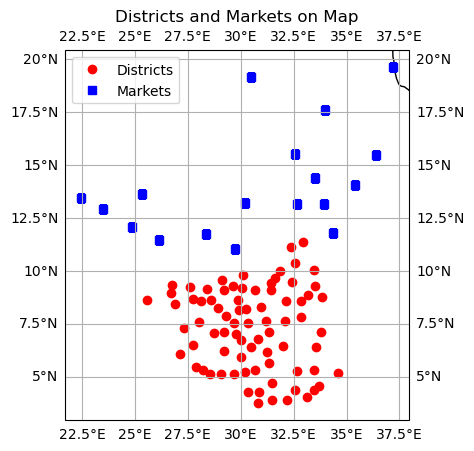

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Sample data for df1 (districts) and df2 (markets)
data1 = pd.read_csv('data/food_crises_cleaned.csv', parse_dates=['date'])
df1 = data1[['district','centy', 'centx']].drop_duplicates().reset_index(drop=True)

data2 = pd.read_csv('data/wfp_food_prices_sdn.csv', parse_dates=['date'])
df2 = data2[['market', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Create a figure and axis with a Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot districts as red circles
ax.plot(df1['centx'], df1['centy'], 'ro', label='Districts')

# Plot markets as blue squares
ax.plot(df2['longitude'], df2['latitude'], 'bs', label='Markets')

# Add gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.COASTLINE)

# Set the title and legend
plt.title('Districts and Markets on Map')
plt.legend()

# Show the plot
plt.show()


In [31]:
!pip install cartopy

  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/bb/50/ab5495dcc22587179134cd37e6534212babeda78e86bda311c37c773f086/Cartopy-0.22.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/46.5 kB ? eta -:--:--
     ---------------------------------------- 46.5/46.5 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
   - -------------------------------------- 0.4/11.2 MB 9.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/11.2 MB 9.2 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/11.2 MB 9.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.2 MB 9.3 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/11.2 MB 9.5 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/11.2 MB 9.9 MB/s eta 0:00:01
   ------------ --------------------------- 3.5/11.2 MB 11.1 MB/s eta 0:00:01
   -------------- -----------

In [29]:
df1

NameError: name 'df1' is not defined